# Validating "Attention-based CNN" for classification of ECG data

In this project we have implemented the deep learning model proposed by Liu et al. in their paper for arrhythmia diagnosis using ECG signal. Arrhythmia is a heart condition which causes abnormal electrical impulses in the heart. Such irregularities cause improper blood circulation to the organs all over the body, and could lead to heart attack or strokes.

ECG signals are used to detect arrhythmia, however, the traditional techniques of detection require a pre-processed, denoised signal. The methods applied for pre-processing are complex and the resulting signals might not preserve all the important features of the signals. By advent of deep learning, particularly, the attention layer, the authors have proposed that the detection could be performed using raw ECG signals. The attention layer is user to assign weight to each slice of the signal, based on its importance. They hypothesise that the peaks would have a higher weight compared to their noisy counterparts and thus, the CNN could process the weighted information accordingly.

In this notebook, we have validated the model using ECG data from the MIT-BIH website.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install torch

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats, io

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.utils.data as Data
import pickle
import numpy as np
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, classification_report
from torch.nn.parameter import Parameter

import torch
import torch.nn as nn
import torch.utils.data as Data
import pickle
import numpy as np
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, classification_report
from torch.nn.parameter import Parameter

%matplotlib inline

In [6]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

We have considered the Ventricula ectopic beat for classification. This type has two ECG classes in the MIT-BIH dataset- Premature ventricular contraction (V) and Ventricular espcape beat (E)

In [23]:
class_labels= ['N', 'S', 'V', 'F', 'Q']

In [24]:
path = your_path
window_size = 240

classes = class_labels
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [25]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt
records = list()
annotations = list()
filenames.sort()

In [26]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

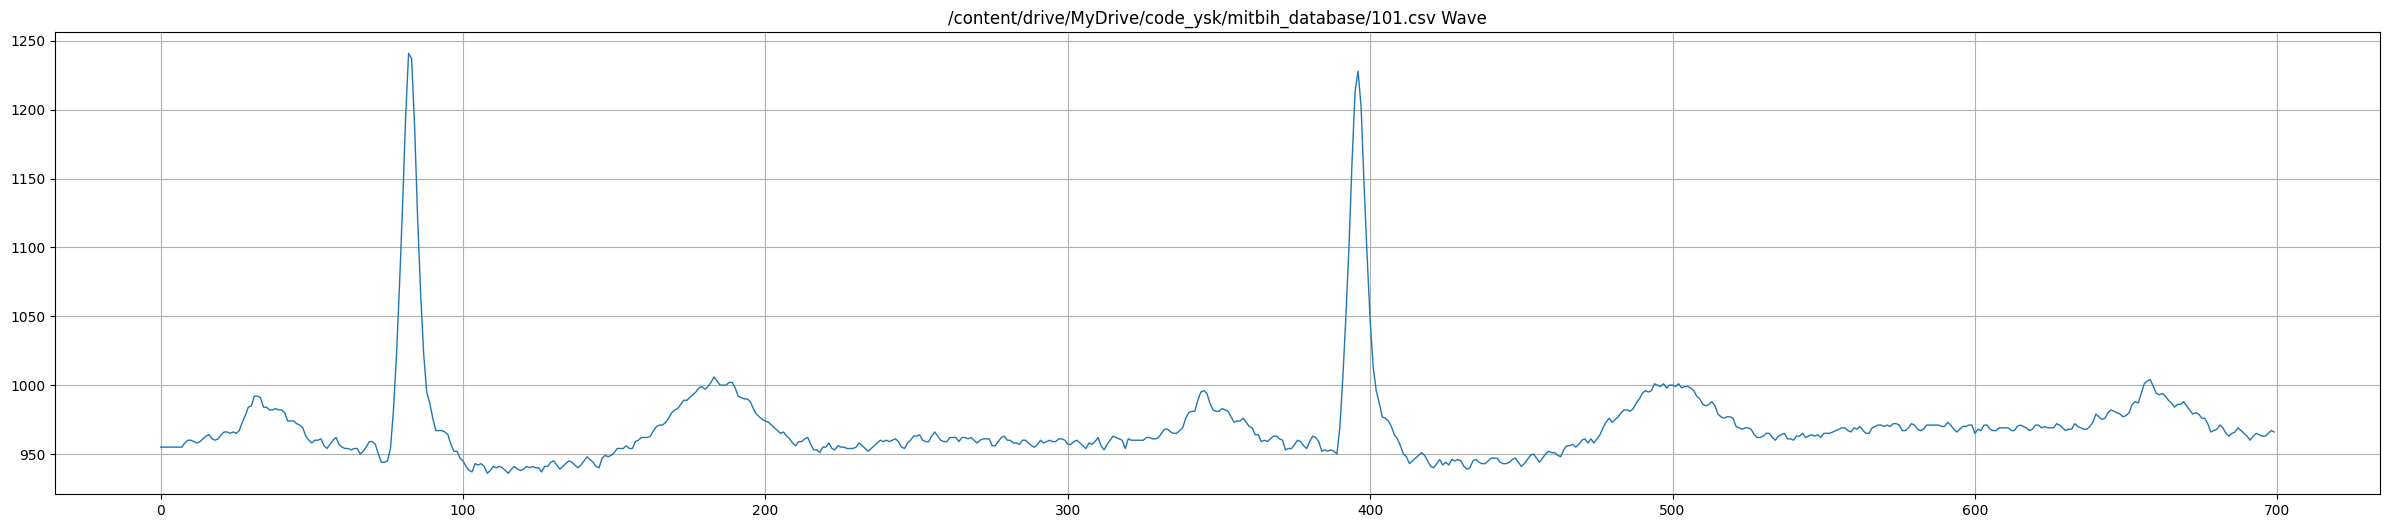

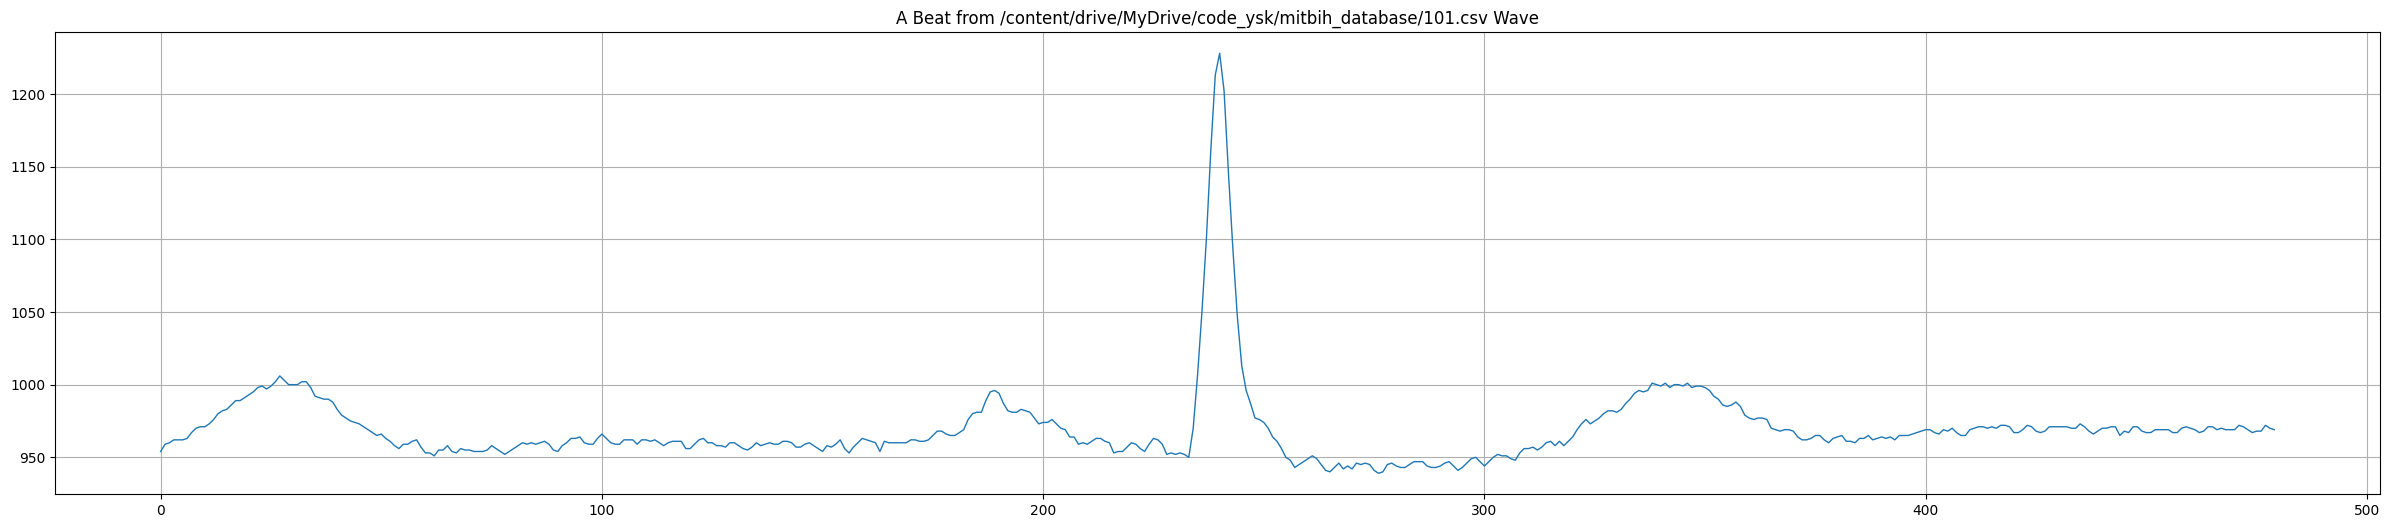

(82958, 480) (82958,)


In [27]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat
                    if r == 1 and not example_beat_printed:
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [28]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X))

(82958, 481)


0    74994
2     7127
3      802
4       33
1        2
Name: 480, dtype: int64


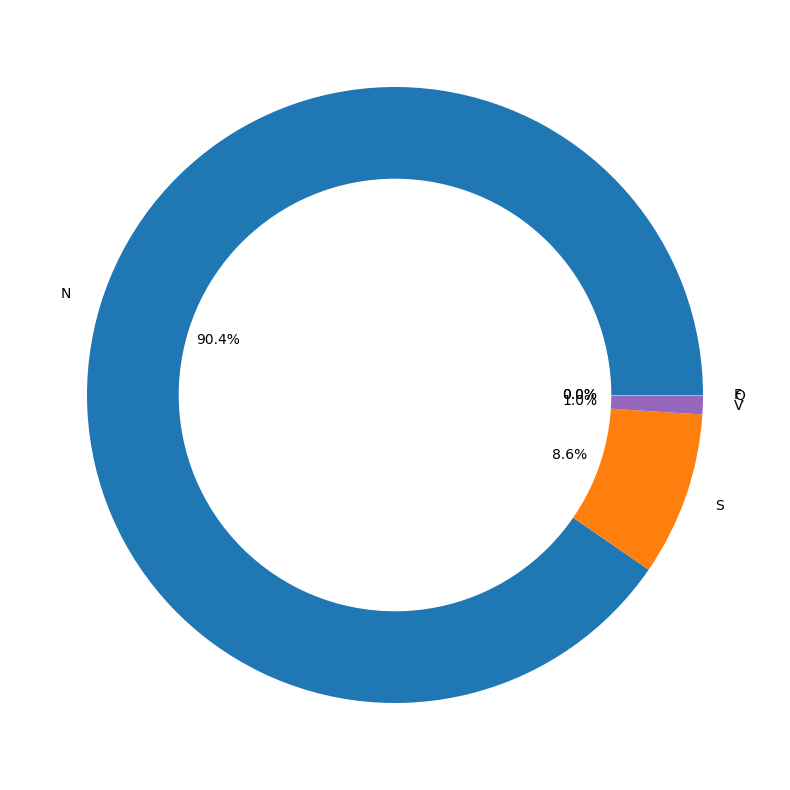

In [37]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=class_labels, colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [39]:
plot= X_train_df

[]

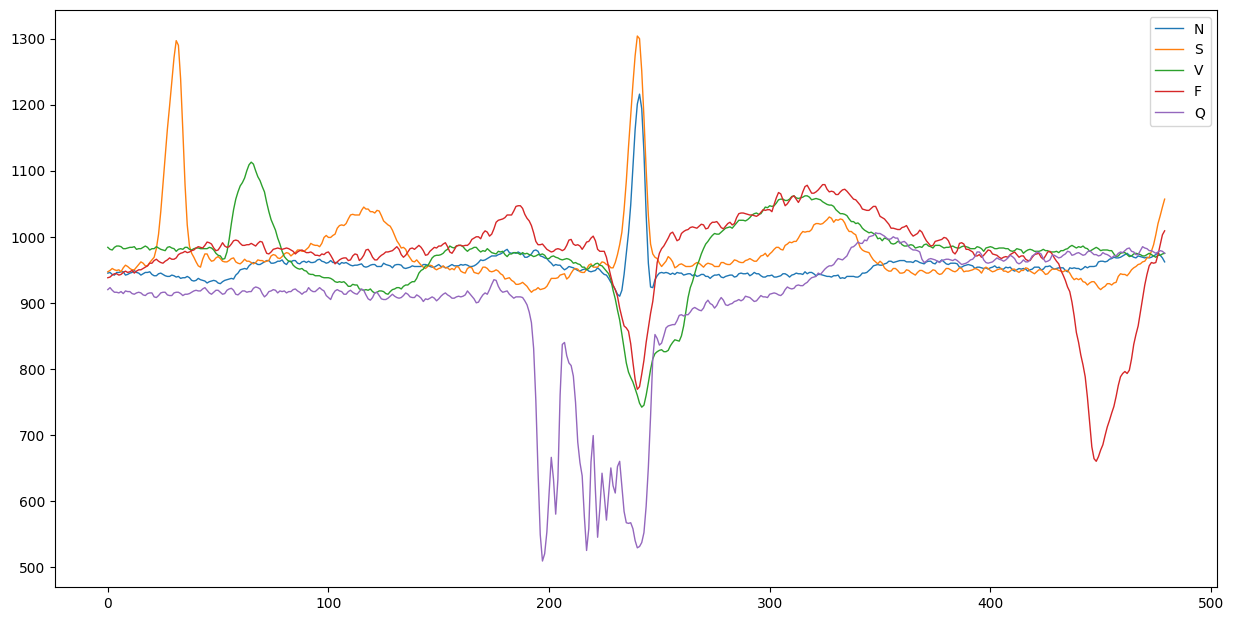

In [40]:
plt.figure(figsize= [15, 7.5])

plt.grid(None)
for i in range(0, len(class_labels)):
    plt.plot(plot.loc[plot[480].isin([i])].iloc[1, 0:480])


plt.legend(class_labels)
plt.plot()

0    74994
2     7127
3      802
4       33
1        2
Name: 480, dtype: int64


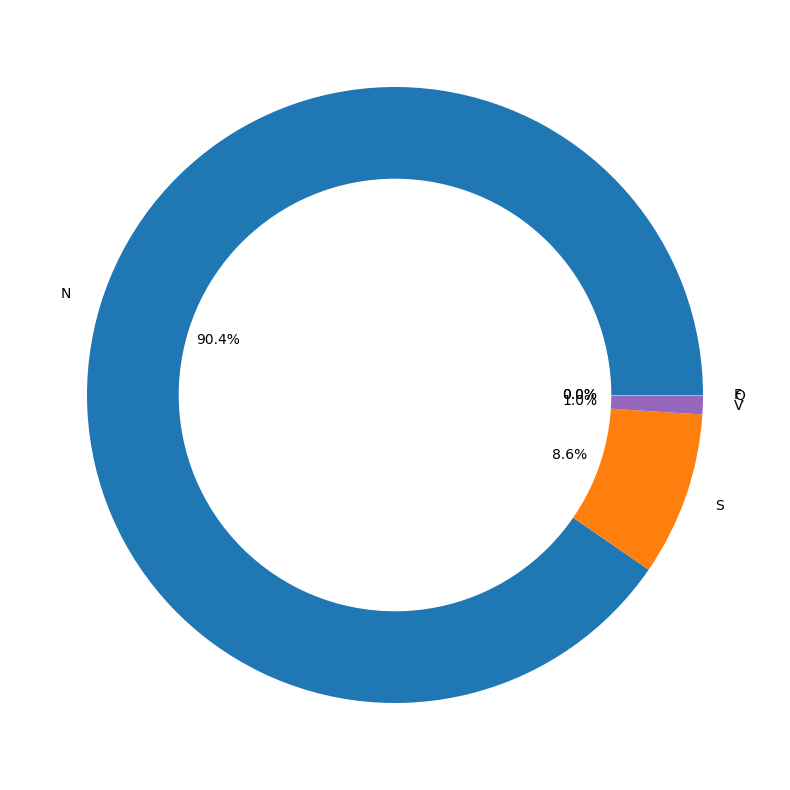

In [41]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=class_labels, colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [42]:
def one_hot(y_, maxvalue = None):
    if maxvalue==None:
        y_ = y_.reshape(len(y_))
        n_values = np.max(y_) + 1
    else:
        n_values = maxvalue
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

In [43]:
with_gpu = torch.cuda.is_available()
if with_gpu:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('We are using %s now.' %device)

We are using cpu now.


In [44]:
EPOCH = 50
LR = 0.001

In [45]:
data= X_train_df
data= data.to_numpy()

In [46]:
n_fea = data.shape[-1] - 1

In [47]:
# normalization
feature_all = data[:, 0:n_fea]
label_all = data[:, n_fea:n_fea+1]
feature_normalized=preprocessing.scale(feature_all)
all = np.hstack((feature_normalized, label_all))

In [74]:
n_seg = all.shape[0]
np.random.shuffle(all)
all = torch.Tensor(all).to(device)

<ipython-input-74-0765a4005dd5>:2: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(all)


In [75]:
ratio = 0.8
train_data = all[: int(ratio*n_seg)]
test_data = all[int(ratio*n_seg):]

In [76]:
BATCH_SIZE = int(all.shape[0]*0.05)

In [77]:
train_x_3d = train_data[:, 0:480].reshape([-1, 2, 240])
train_x_3d = torch.unsqueeze(train_x_3d, dim=1)

In [78]:
train_y_ = train_data[:, 480:481].long().to(device)

In [79]:
train_data = Data.TensorDataset(train_x_3d, train_y_)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)

In [80]:
test_data_3d = test_data[:, 0:480].reshape([-1, 2, 240])
test_data_3d = torch.unsqueeze(test_data_3d, dim=1)

In [81]:
test_y = test_data[:, 480:481].long().to(device)

In [82]:
class CNN(nn.Module):
    def __init__(self,):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=4,
                kernel_size=[2, 2],
                stride=1,
                padding=[1,2],
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[1, 2])
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, [2, 2], 1, padding=[1,2]),
            nn.ReLU(),
            nn.MaxPool2d([1,2])
        )

        self.fc = nn.Linear(1984, 200)
        self.out = nn.Linear(200, 5)
        self.weight = Parameter(torch.Tensor(2, 32))


    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc(x))
        x = F.dropout(x, 0.2)

        output = self.out(x)
        return output, x

cnn = CNN()
cnn.to(device)

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()
import time

In [83]:
model_name= "model_best_4"

In [86]:
best_acc = 0
best_auc = 0
time_s = time.perf_counter()

train_acc_list= []
test_acc_list= []

train_loss_list= []
test_loss_list=[]

# training & testing
for epoch in range(EPOCH):
    for step, (train_x, train_y) in enumerate(train_loader):

        output = cnn(train_x)[0]

        loss = loss_func(output, train_y.squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step == 0:
            test_output, last_layer = cnn(test_data_3d)
            test_loss = loss_func(test_output, test_y.squeeze(1))

            test_y_score = one_hot(test_y.data.cpu().numpy())
            pred_score = F.softmax(test_output, dim=0).data.cpu().numpy()
            auc_score = roc_auc_score(test_y_score, pred_score)


            pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()
            pred_train = torch.max(output, 1)[1].data.cpu().numpy()
            train_acc = float((pred_train == train_y.squeeze(1).data.cpu().numpy()).astype(int).sum()) / float(train_y.size(0))
            test_acc = float((pred_y == test_y.squeeze(1).data.cpu().numpy()).astype(int).sum()) / float(test_y.size(0))

            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)

            train_loss_list.append(loss.item())
            test_loss_list.append(test_loss.item())

            print('Epoch: ', epoch, '| STEP: ', step, '|train loss: %.4f' % loss.item(),
                  ' train ACC: %.4f' % train_acc, '| test loss: %.4f' % test_loss.item(),
                  'test ACC: %.4f' % test_acc,
                  '| AUC: %.4f' % auc_score)


            """Save model"""
            if auc_score > best_auc:
                best_auc = auc_score
                torch.save(cnn.state_dict(), path + model_name + '.pt')
                print('model saved, for auc: {}'.format(best_auc))


Epoch:  0 | STEP:  0 |train loss: 0.8283  train ACC: 0.8970 | test loss: 0.5916 test ACC: 0.9034 | AUC: 0.3622
model saved, for auc: 0.3621923703633042
Epoch:  1 | STEP:  0 |train loss: 0.3368  train ACC: 0.9002 | test loss: 0.2894 test ACC: 0.9062 | AUC: 0.6597
model saved, for auc: 0.659660847417763
Epoch:  2 | STEP:  0 |train loss: 0.1998  train ACC: 0.9301 | test loss: 0.1831 test ACC: 0.9348 | AUC: 0.7742
model saved, for auc: 0.7742088217379435
Epoch:  3 | STEP:  0 |train loss: 0.1533  train ACC: 0.9506 | test loss: 0.1413 test ACC: 0.9537 | AUC: 0.8160
model saved, for auc: 0.8160057639609042
Epoch:  4 | STEP:  0 |train loss: 0.1270  train ACC: 0.9617 | test loss: 0.1157 test ACC: 0.9625 | AUC: 0.8590
model saved, for auc: 0.8589619409569271
Epoch:  5 | STEP:  0 |train loss: 0.1132  train ACC: 0.9674 | test loss: 0.1032 test ACC: 0.9661 | AUC: 0.8761
model saved, for auc: 0.876086935453426
Epoch:  6 | STEP:  0 |train loss: 0.1062  train ACC: 0.9684 | test loss: 0.0958 test ACC: 

[]

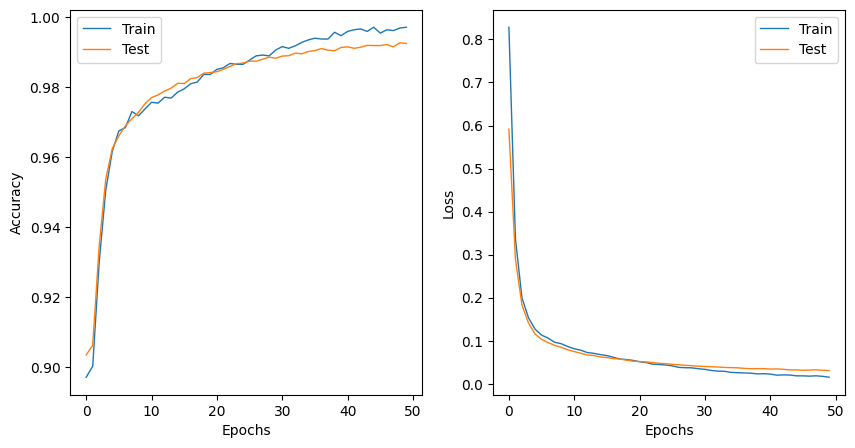

In [87]:
plt.figure(figsize= [10, 5])

plt.subplot(1, 2, 1)

plt.grid(False)
plt.plot(train_acc_list)
plt.plot(test_acc_list)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend(['Train', 'Test'])

plt.subplot(1, 2, 2)

plt.grid(False)
plt.plot(train_loss_list)
plt.plot(test_loss_list)

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend(['Train', 'Test'])

plt.plot()

In [88]:
"""load best model"""
cnn.load_state_dict(torch.load(path + model_name + '.pt'))
cnn.eval()
test_output = cnn(test_data_3d)[0]

test_y_score = one_hot(test_y.data.cpu().numpy())
pred_score = F.softmax(test_output, dim=0).data.cpu().numpy()
pred_y = torch.argmax(torch.from_numpy(pred_score), dim=1).data.cpu().numpy()

auc_score = roc_auc_score(test_y_score, pred_score)

print('===========================================================')

print(classification_report(test_y.data.cpu().numpy(), pred_y, digits=4))
print("AUC: ", auc_score)

              precision    recall  f1-score   support

           0     1.0000    0.0154    0.0304     14989
           1     0.0003    1.0000    0.0005         2
           2     0.9487    0.0264    0.0513      1404
           3     0.2111    0.8660    0.3394       194
           4     0.0004    1.0000    0.0007         3

    accuracy                         0.0266     16592
   macro avg     0.4321    0.5815    0.0845     16592
weighted avg     0.9861    0.0266    0.0357     16592

AUC:  0.9064388795914476


In [89]:
fp= {}
tp= {}
auc_= {}

for i in range(test_y_score.shape[1]):
    fp[i], tp[i], thresh= roc_curve(test_y_score[:,i], pred_score[:, i])
    auc_[i]= auc(fp[i], tp[i])

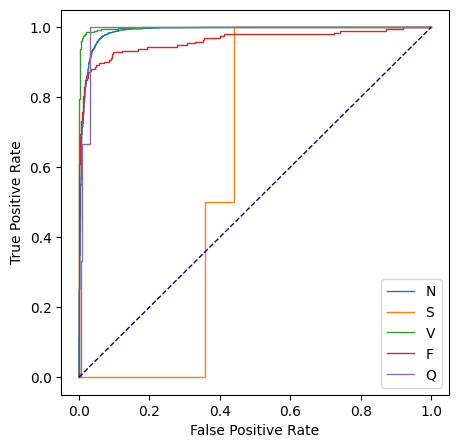

In [90]:
plt.figure(figsize= [5, 5])
plt.grid(False)

for i in range(test_y_score.shape[1]):
    plt.plot(fp[i], tp[i])

plt.legend(class_labels)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot([0,1], [0, 1], color= "navy", linestyle= "--")

plt.show()